In [ ]:
# Install required libraries
!pip install -q datasets[torch] scikit-learn pandas matplotlib seaborn imbalanced-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change these if you want
DRIVE_CACHE_DIR = "/content/drive/MyDrive/hf_datasets_cache"
OUTPUT_DIR = "/content/drive/MyDrive/CIC_IDS2017_pipeline_outputs"

import os
os.makedirs(DRIVE_CACHE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Cache dir:", DRIVE_CACHE_DIR)
print("Output dir:", OUTPUT_DIR)


In [ ]:
from datasets import load_dataset
print("Loading dataset (this may take a few minutes)...")
ds = load_dataset("c01dsnap/CIC-IDS2017", split="train", cache_dir=DRIVE_CACHE_DIR)

In [ ]:
import pandas as pd
df = ds.to_pandas()
print("DataFrame shape:", df.shape)
display(df.head())


In [ ]:
print(df.columns.tolist())


In [ ]:
# Remove leading/trailing spaces from ALL column names
df.columns = df.columns.str.strip()

# Confirm it's fixed
print(df.columns[-5:])

In [ ]:
def map_label_to_5(lbl: str):
    s = lbl.lower()
    if 'benign' in s:
        return 'Benign'
    if 'ddos' in s or 'dos' in s or 'syn' in s:
        return 'DoS'
    if 'brute' in s or 'bruteforce' in s:
        return 'BruteForce'
    if 'bot' in s:
        return 'Botnet'
    return 'Web_And_Other'

df['Label_5cat'] = df['Label'].apply(map_label_to_5)
print(df['Label_5cat'].value_counts())

# Save a quick mapping preview to Drive
df[['Label','Label_5cat']].drop_duplicates().to_csv(
    "/content/drive/MyDrive/CIC_IDS2017_pipeline_outputs/label_mapping_preview.csv", index=False)

In [ ]:
# 1️⃣ Re-import libraries
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 2️⃣ Reload dataset (this will be fast since it’s cached in Drive)
DRIVE_CACHE_DIR = "/content/drive/MyDrive/hf_datasets_cache"
ds = load_dataset("c01dsnap/CIC-IDS2017", split="train", cache_dir=DRIVE_CACHE_DIR)
df = ds.to_pandas()

# 3️⃣ Clean up column names
df.columns = df.columns.str.strip()

# 4️⃣ Rebuild your 5-category label
def map_label_to_5(lbl: str):
    s = lbl.lower()
    if 'benign' in s:
        return 'Benign'
    if 'ddos' in s or 'dos' in s or 'syn' in s:
        return 'DoS'
    if 'brute' in s or 'bruteforce' in s:
        return 'BruteForce'
    if 'bot' in s:
        return 'Botnet'
    return 'Web_And_Other'

df['Label_5cat'] = df['Label'].apply(map_label_to_5)

# 5️⃣ Keep only numeric columns and clean up values
non_feature_cols = ['Label', 'Label_5cat']
y = df['Label_5cat'].copy()
X = df.drop(columns=[c for c in non_feature_cols if c in df.columns])
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
print("Numeric feature count:", len(num_cols))

X_num = X[num_cols].copy()
X_num = X_num.replace([np.inf, -np.inf], np.nan)
X_num = X_num.clip(lower=-1e10, upper=1e10)

# 6️⃣ Impute + scale
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X_num)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

X_processed = pd.DataFrame(X_scaled, columns=num_cols)
print("✅ Clean & scaled data ready.")
print("Processed shape:", X_processed.shape)

In [ ]:
# 🚀 FULL RESET & PREPROCESS PIPELINE

# 1️⃣ Imports
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 2️⃣ Reload dataset (it’ll use your Drive cache, not re-download)
DRIVE_CACHE_DIR = "/content/drive/MyDrive/hf_datasets_cache"
ds = load_dataset("c01dsnap/CIC-IDS2017", split="train", cache_dir=DRIVE_CACHE_DIR)
df = ds.to_pandas()

# 3️⃣ Clean up column names
df.columns = df.columns.str.strip()

# 4️⃣ Map labels to 5 categories
def map_label_to_5(lbl: str):
    s = lbl.lower()
    if 'benign' in s:
        return 'Benign'
    if 'ddos' in s or 'dos' in s or 'syn' in s:
        return 'DoS'
    if 'brute' in s or 'bruteforce' in s:
        return 'BruteForce'
    if 'bot' in s:
        return 'Botnet'
    return 'Web_And_Other'

df['Label_5cat'] = df['Label'].apply(map_label_to_5)

# 5️⃣ Prepare numeric features
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
X_num = df[num_cols].copy()

# Clean infinities/outliers
X_num = X_num.replace([np.inf, -np.inf], np.nan)
X_num = X_num.clip(lower=-1e10, upper=1e10)

# Handle missing + scale
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X_num)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# Convert back to DataFrame
X_processed = pd.DataFrame(X_scaled, columns=num_cols)
y = df['Label_5cat'].copy()

print("✅ All data ready!")
print("X_processed:", X_processed.shape)
print("y:", y.shape)
print("Labels:", y.value_counts())



In [ ]:
from sklearn.model_selection import train_test_split

# 🧩 use a sample of the dataset to avoid memory crashes in Colab
sample_fraction = 0.2
X_sampled, _, y_sampled, _ = train_test_split(
    X_processed, y, train_size=sample_fraction, stratify=y, random_state=42
)

# Split into 70% train / 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.3, stratify=y_sampled, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

In [ ]:
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE

# SMOTE balances the minority classes in the training set
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("✅ After SMOTE balancing:")
print(y_train_bal.value_counts())


In [ ]:
# 🚀 Full rebuild: dataset + preprocess + SMOTE + splits

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1️⃣ Reload dataset from cache (fast!)
DRIVE_CACHE_DIR = "/content/drive/MyDrive/hf_datasets_cache"
ds = load_dataset("c01dsnap/CIC-IDS2017", split="train", cache_dir=DRIVE_CACHE_DIR)
df = ds.to_pandas()

# 2️⃣ Clean column names
df.columns = df.columns.str.strip()

# 3️⃣ Map labels into 5 categories
def map_label_to_5(lbl: str):
    s = lbl.lower()
    if 'benign' in s:
        return 'Benign'
    if 'ddos' in s or 'dos' in s or 'syn' in s:
        return 'DoS'
    if 'brute' in s or 'bruteforce' in s:
        return 'BruteForce'
    if 'bot' in s:
        return 'Botnet'
    return 'Web_And_Other'

df['Label_5cat'] = df['Label'].apply(map_label_to_5)
y = df['Label_5cat'].copy()

# 4️⃣ Keep only numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
X_num = df[num_cols].copy()

# 5️⃣ Replace infinities/outliers, impute, scale
X_num = X_num.replace([np.inf, -np.inf], np.nan)
X_num = X_num.clip(lower=-1e10, upper=1e10)

imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X_num)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

X_processed = pd.DataFrame(X_scaled, columns=num_cols)
print("✅ Processed shape:", X_processed.shape)

# 6️⃣ Split into train/test
sample_fraction = 0.2  # keeps runtime light
X_sampled, _, y_sampled, _ = train_test_split(
    X_processed, y, train_size=sample_fraction, stratify=y, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.3, stratify=y_sampled, random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape)

# 7️⃣ Apply SMOTE to balance
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("✅ After SMOTE balancing:")
print(y_train_bal.value_counts())

In [ ]:
import joblib
SAVE_DIR = "/content/drive/MyDrive/CIC_IDS2017_pipeline_outputs/"
joblib.dump((X_train_bal, y_train_bal, X_test, y_test), SAVE_DIR + "balanced_data.pkl")
print("✅ Saved to", SAVE_DIR)

In [ ]:
# 🚀 Optimized Intrusion Detection Model Training (Colab-friendly)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score
)
from sklearn.preprocessing import label_binarize, LabelEncoder
from itertools import cycle
import numpy as np

# --- Encode labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_bal)
y_test_enc = le.transform(y_test)

# --- Model definitions (optimized) ---
models = {
    "Logistic Regression": LogisticRegression(
        solver="saga", max_iter=300, random_state=42, n_jobs=-1
    ),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=42),
}

# --- Helper function: plot ROC for multiclass ---
def plot_multiclass_roc(model, X_test, y_test_enc, model_name):
    if not hasattr(model, "predict_proba"):
        return
    y_score = model.predict_proba(X_test)
    y_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))
    n_classes = y_bin.shape[1]
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_bin[:, i], y_score[:, i])
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green"])
    plt.figure(figsize=(6, 5))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

# --- Train + evaluate ---
for name, model in models.items():
    print(f"\n🚀 Training {name}...")

    # downsample for very heavy models to speed up
    if name == "Logistic Regression":
        sample_frac = 0.1
        X_small = X_train_bal.sample(frac=sample_frac, random_state=42)
        y_small = y_train_enc[:len(X_small)]
        model.fit(X_small, y_small)
    elif name == "SVM (RBF)":
        sample_frac = 0.2
        X_small = X_train_bal.sample(frac=sample_frac, random_state=42)
        y_small = y_train_enc[:len(X_small)]
        model.fit(X_small, y_small)
    else:
        model.fit(X_train_bal, y_train_enc)

    y_pred_train = model.predict(X_train_bal)
    y_pred_test = model.predict(X_test)

    acc_train = accuracy_score(y_train_enc, y_pred_train)
    acc_test = accuracy_score(y_test_enc, y_pred_test)
    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Test Accuracy:  {acc_test:.4f}")

    print("\nClassification Report (Test):")
    print(classification_report(y_test_enc, y_pred_test, target_names=le.classes_))

    cm = confusion_matrix(y_test_enc, y_pred_test)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    if hasattr(model, "predict_proba"):
        plot_multiclass_roc(model, X_test, y_test_enc, name)

# --- K-MEANS ---
print("\n🚀 Training K-Means...")
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(le.classes_), random_state=42)
kmeans.fit(X_train_bal)
print("K-Means done. Inertia:", kmeans.inertia_)

# --- ISOLATION FOREST ---
print("\n🚀 Training Isolation Forest...")
iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(X_train_bal)
print("Isolation Forest done.")

print("\n✅ All models trained & evaluated!")

In [ ]:
import joblib

# Load the preprocessed + SMOTE-balanced data you saved earlier
X_train_bal, y_train_bal, X_test, y_test = joblib.load(
    "/content/drive/MyDrive/CIC_IDS2017_pipeline_outputs/balanced_data.pkl"
)

print("✅ Data reloaded successfully!")
print("Training shape:", X_train_bal.shape)
print("Testing shape:", X_test.shape)
print(y_train_bal.value_counts())



In [ ]:
sample_frac = 0.1  # can drop to 0.05 if it still feels slow
X_train_small = X_train_bal.sample(frac=sample_frac, random_state=42)
y_train_small = y_train_bal.loc[X_train_small.index]

print("Subset ready:", X_train_small.shape)
print(y_train_small.value_counts())


In [ ]:
import joblib

# load your saved smote-balanced data from drive
X_train_bal, y_train_bal, X_test, y_test = joblib.load(
    "/content/drive/MyDrive/CIC_IDS2017_pipeline_outputs/balanced_data.pkl"
)

print("✅ reloaded balanced data")
print("Train shape:", X_train_bal.shape)
print("Test shape:", X_test.shape)
print(y_train_bal.value_counts())


✅ reloaded balanced data
Train shape: (1591165, 78)
Test shape: (169845, 78)
Label_5cat
Benign           318233
Web_And_Other    318233
DoS              318233
Botnet           318233
BruteForce       318233
Name: count, dtype: int64


In [ ]:
sample_frac = 0.1   # 10% subset; you can go 0.05 if colab still lags
X_train_small = X_train_bal.sample(frac=sample_frac, random_state=42)
y_train_small = y_train_bal.loc[X_train_small.index]

print("Subset ready:", X_train_small.shape)
print(y_train_small.value_counts())


Subset ready: (159116, 78)
Label_5cat
Web_And_Other    32042
BruteForce       31899
Botnet           31878
Benign           31679
DoS              31618
Name: count, dtype: int64


In [ ]:
import joblib

# Reload your preprocessed + SMOTE-balanced data
X_train_bal, y_train_bal, X_test, y_test = joblib.load(
    "/content/drive/MyDrive/CIC_IDS2017_pipeline_outputs/balanced_data.pkl"
)

# Create smaller subset (10%)
sample_frac = 0.1
X_train_small = X_train_bal.sample(frac=sample_frac, random_state=42)
y_train_small = y_train_bal.loc[X_train_small.index]

print("✅ Subset created ->", X_train_small.shape)
print(y_train_small.value_counts())


✅ Subset created -> (159116, 78)
Label_5cat
Web_And_Other    32042
BruteForce       31899
Botnet           31878
Benign           31679
DoS              31618
Name: count, dtype: int64



🚀 Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Train Acc: 0.8455 | Test Acc: 0.7853
Classification Report:
               precision    recall  f1-score   support

       Benign       0.99      0.74      0.85    136386
       Botnet       0.01      0.73      0.01       118
   BruteForce       0.01      0.89      0.03        90
          DoS       0.70      0.97      0.82     22842
Web_And_Other       0.63      0.91      0.75     10409

     accuracy                           0.79    169845
    macro avg       0.47      0.85      0.49    169845
 weighted avg       0.93      0.79      0.84    169845



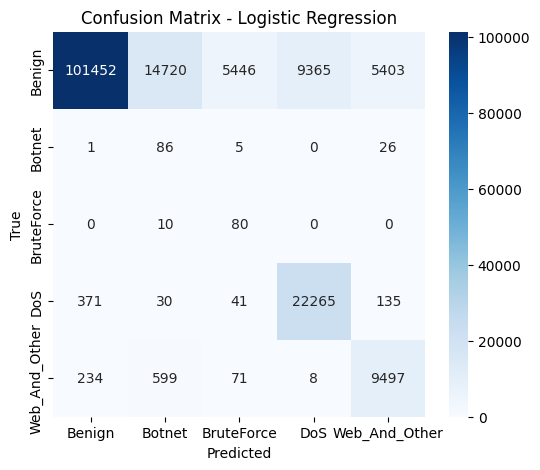

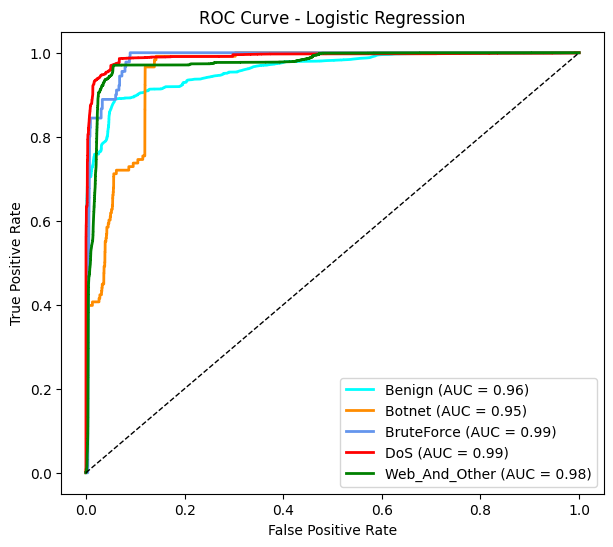


🚀 Training Decision Tree...
Decision Tree Train Acc: 1.0000 | Test Acc: 0.9969
Classification Report:
               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    136386
       Botnet       0.62      0.94      0.75       118
   BruteForce       0.54      0.83      0.65        90
          DoS       0.99      1.00      0.99     22842
Web_And_Other       0.99      0.99      0.99     10409

     accuracy                           1.00    169845
    macro avg       0.83      0.95      0.88    169845
 weighted avg       1.00      1.00      1.00    169845



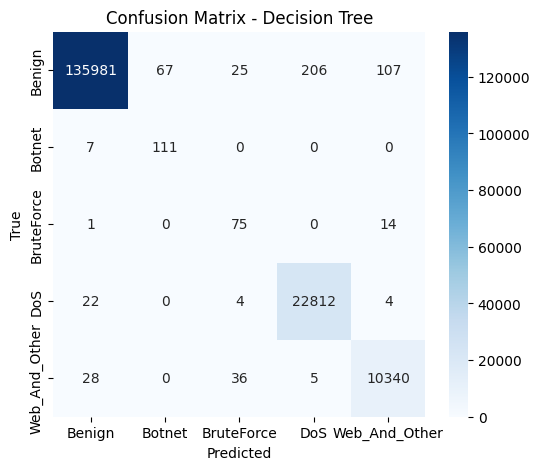

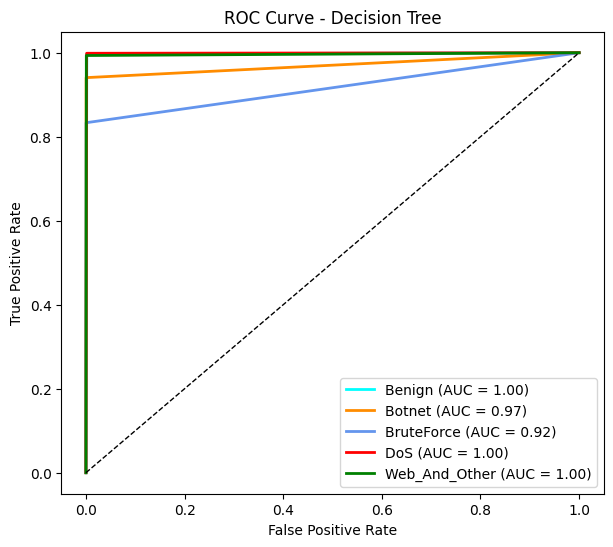


🚀 Training Random Forest...
Random Forest Train Acc: 1.0000 | Test Acc: 0.9980
Classification Report:
               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    136386
       Botnet       0.58      0.91      0.71       118
   BruteForce       0.70      0.98      0.82        90
          DoS       1.00      1.00      1.00     22842
Web_And_Other       0.99      1.00      0.99     10409

     accuracy                           1.00    169845
    macro avg       0.86      0.98      0.90    169845
 weighted avg       1.00      1.00      1.00    169845



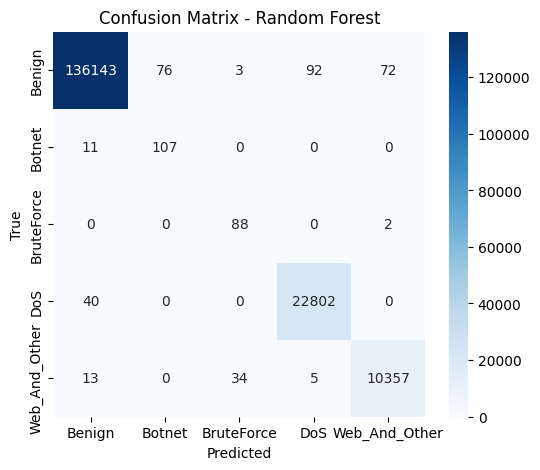

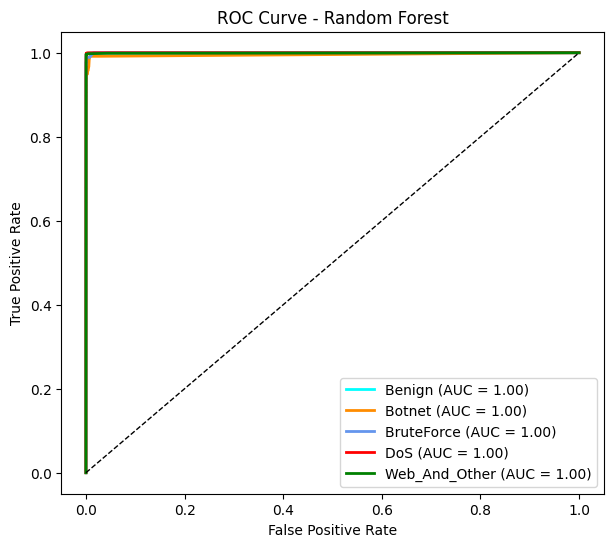


🚀 Training SVM (RBF)...
SVM (RBF) Train Acc: 0.9708 | Test Acc: 0.9014
Classification Report:
               precision    recall  f1-score   support

       Benign       1.00      0.88      0.94    136386
       Botnet       0.02      0.98      0.05       118
   BruteForce       0.03      1.00      0.06        90
          DoS       0.80      1.00      0.88     22842
Web_And_Other       0.76      0.97      0.85     10409

     accuracy                           0.90    169845
    macro avg       0.52      0.97      0.56    169845
 weighted avg       0.96      0.90      0.92    169845



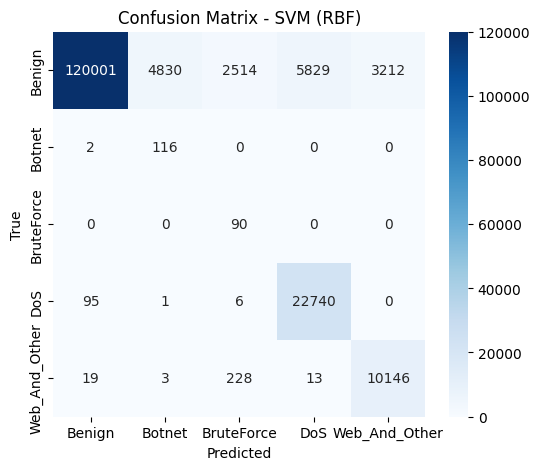

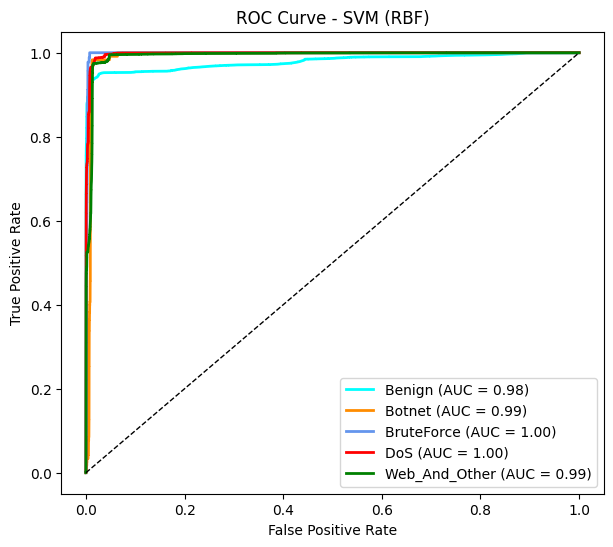


🚀 Training K-Means...


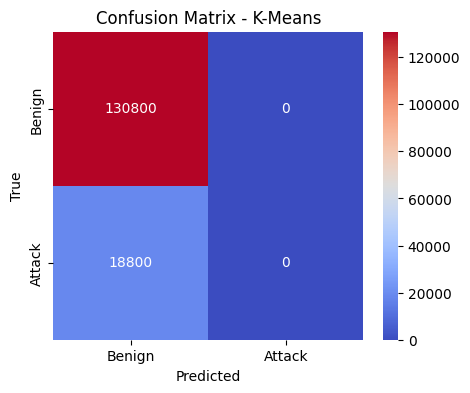

K-Means Accuracy: 0.7701

🚀 Training Isolation Forest...


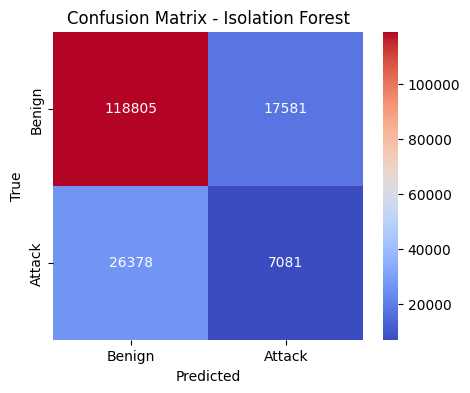

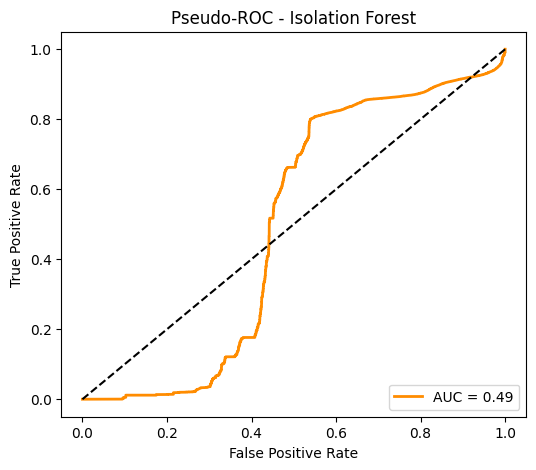

Isolation Forest Accuracy: 0.7412

🎯 Final Model Accuracies:
Logistic Regression: 0.7853
Decision Tree: 0.9969
Random Forest: 0.9980
SVM (RBF): 0.9014
K-Means: 0.7701
Isolation Forest: 0.7412


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
)
from itertools import cycle

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_small)
y_test_enc = le.transform(y_test)
classes = le.classes_

# Define models
models = {
    "Logistic Regression": LogisticRegression(solver="saga", max_iter=300, n_jobs=-1, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42),
    "K-Means": KMeans(n_clusters=len(classes), random_state=42),
    "Isolation Forest": IsolationForest(contamination=0.1, random_state=42)
}

# Track metrics
results = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")

    if name in ["K-Means", "Isolation Forest"]:
        # Unsupervised models
        model.fit(X_train_small)
        y_pred = model.predict(X_test)
        if name == "K-Means":
            # Map clusters to labels by majority vote
            cluster_map = {}
            for c in np.unique(y_pred):
                mask = (y_pred == c)
                most_common = y_test[mask].mode()[0] if mask.any() else "Benign"
                cluster_map[c] = most_common
            y_pred_labels = np.array([cluster_map[i] for i in y_pred])
        else:
            y_pred_labels = np.where(y_pred == 1, "Benign", "Attack")
        y_true_labels = np.where(y_test == "Benign", "Benign", "Attack")

        acc = accuracy_score(y_true_labels, y_pred_labels)
        results[name] = acc

        # Confusion Matrix
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=["Benign", "Attack"])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                    xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # ROC (pseudo for IsolationForest)
        if name == "Isolation Forest":
            y_true_bin = label_binarize(y_true_labels, classes=["Attack", "Benign"]).ravel()
            y_pred_scores = model.decision_function(X_test)
            fpr, tpr, _ = roc_curve(y_true_bin, y_pred_scores)
            roc_auc = roc_auc_score(y_true_bin, y_pred_scores)
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0,1],[0,1],'k--')
            plt.title(f"Pseudo-ROC - {name}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.show()

        print(f"{name} Accuracy: {acc:.4f}")

    else:
        # Supervised models
        model.fit(X_train_small, y_train_small)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)

        acc_train = model.score(X_train_small, y_train_small)
        acc_test = model.score(X_test, y_test)
        results[name] = acc_test

        print(f"{name} Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # ROC Curve (multiclass)
        y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(classes)))
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

        colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green"])
        plt.figure(figsize=(7,6))
        for i, color in zip(range(len(classes)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0,1],[0,1],'k--',lw=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend(loc="lower right")
        plt.show()

# Display final comparison
print("\n🎯 Final Model Accuracies:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


In [2]:
import os, shutil

nb_name = "CIC_IDS_2018_ML.ipynb"  # this file's name
src_nb = f"/content/{nb_name}"
dst_nb = f"/content/intrusion-detection-project/notebooks/{nb_name}"

if os.path.exists(src_nb):
    shutil.copy(src_nb, dst_nb)
    print(f"✅ Notebook copied to {dst_nb}")
else:
    print("⚠️ Notebook not found. Make sure you’re running this inside the same Colab session as the notebook file.")

⚠️ Notebook not found. Make sure you’re running this inside the same Colab session as the notebook file.


In [1]:
# 1. Create folder structure in Colab
import os, shutil
proj = "/content/intrusion-detection-project"
if os.path.exists(proj):
    shutil.rmtree(proj)
os.makedirs(proj, exist_ok=True)
os.makedirs(os.path.join(proj, "notebooks"), exist_ok=True)
os.makedirs(os.path.join(proj, "src"), exist_ok=True)
os.makedirs(os.path.join(proj, "results/plots"), exist_ok=True)
os.makedirs(os.path.join(proj, "data"), exist_ok=True)  # placeholder (do not upload raw datasets)
print("Project folder created at:", proj)

Project folder created at: /content/intrusion-detection-project
